In [245]:
def simulate_margin(products, dates, loc, scale):
    import numpy as np
    import pandas as pd

    n_products = len(products)
    n_days = len(dates)    

    scale_diff = scale/np.sqrt(n_days)
    product_baseline = np.random.normal(loc=loc,scale=scale,size=(n_products,1))
    product_diff = np.random.normal(loc=0, scale=scale_diff, size=(n_products, n_days-1))
    margins = np.cumsum(np.concatenate([product_baseline, product_diff], axis=1), axis=1)
    margins = pd.DataFrame(margins, columns=dates)
    margins["product_id"] = products
    return margins

def plot_simulated_margin(margins):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1,2, figsize=(20,7.5))

    temp_margins = pd.melt(margins, id_vars=["product_id"],
        var_name="date", value_name="margin")

    # walk
    sns.lineplot(data=temp_margins,
        x="date", y="margin", hue="product_id",
        legend=False, palette=sns.color_palette("rocket_r", as_cmap=True),
        alpha=0.5, ax=axs[0]);
    axs[0].set_ylabel("$m_{t}^{p}$");
    axs[0].tick_params(axis='x', rotation=90);
    axs[0].set_xlabel("date");

    # hist
    sns.histplot(data=temp_margins,
        x="margin", bins=50,
        color=sns.color_palette("rocket",10)[1],
        ax=axs[1]);
    axs[1].set_ylabel("frequency");
    axs[1].set_xlabel("$m_{t}^{p}$");

/tmp/ipykernel_2930/3376665456.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.loc[:,"date"] = purchases.event_time.dt.date
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(
/tmp/ipykernel_2930/3376665456.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases["week_start"] = purchases["date"] -\


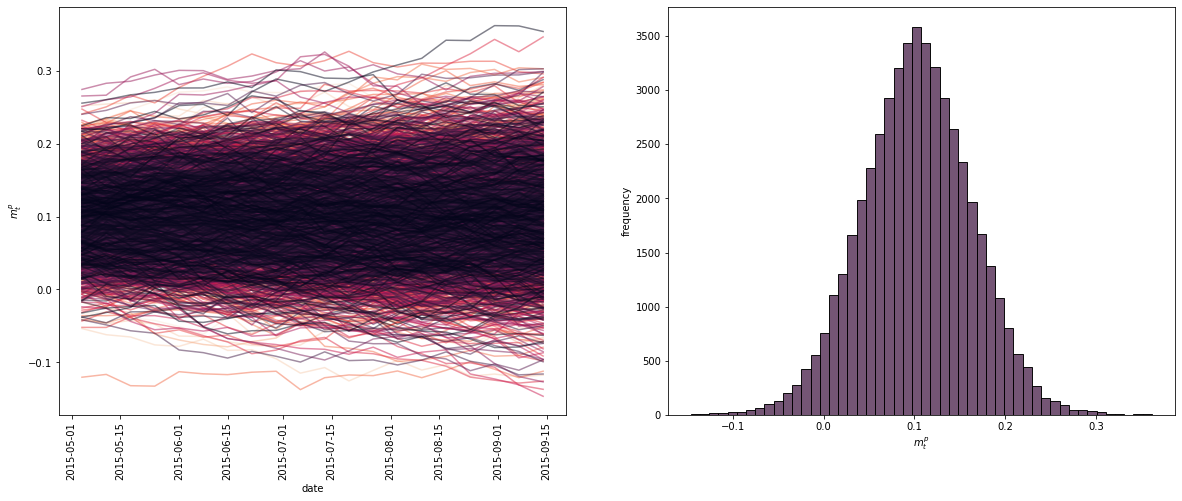

In [246]:
# SIMULATE MARGINS
import numpy as np
import pandas as pd
import datetime

# prepare data
events = pd.read_parquet("../data/raw/retailrocket/events").drop_duplicates()
purchases = events[events.event_type_name=="purchase"]
purchases.loc[:,"date"] = purchases.event_time.dt.date
purchases["week_start"] = purchases["date"] -\
    pd.to_timedelta(purchases["event_time"].dt.dayofweek, unit="d")

# simulation
loc = 0.10
scale = 0.05
dates = purchases.sort_values("week_start").week_start.unique()
products = purchases.product_id.unique()
margins = simulate_margin(products, dates, loc, scale)
plot_simulated_margin(margins.iloc[:2500,:])    

In [247]:
# simple profit
purchases = purchases.merge(pd.melt(margins, id_vars=["product_id"],
        var_name="week_start", value_name="margin"),
    on=["product_id","week_start"], how="inner")
purchases["profit"] = purchases.revenue*purchases.margin
purchases = purchases.groupby(["user_id", "week_start"], as_index=False)\
    .agg(profit=("profit", sum), revenue=("revenue", sum))

In [248]:
# acp
target_size = 4

# weekly profit
from itertools import product
user_wk = pd.DataFrame(product(purchases.user_id.unique(), purchases.week_start.unique()),
    columns=["user_id", "week_start"])

user_wk = user_wk.merge(purchases, on=["user_id","week_start"], how="left")\
    .fillna(0).sort_values("week_start")
user_wk["acp"] = target_size*user_wk.groupby("user_id").profit.cumsum()/\
    (user_wk.groupby("user_id").cumcount()+1)

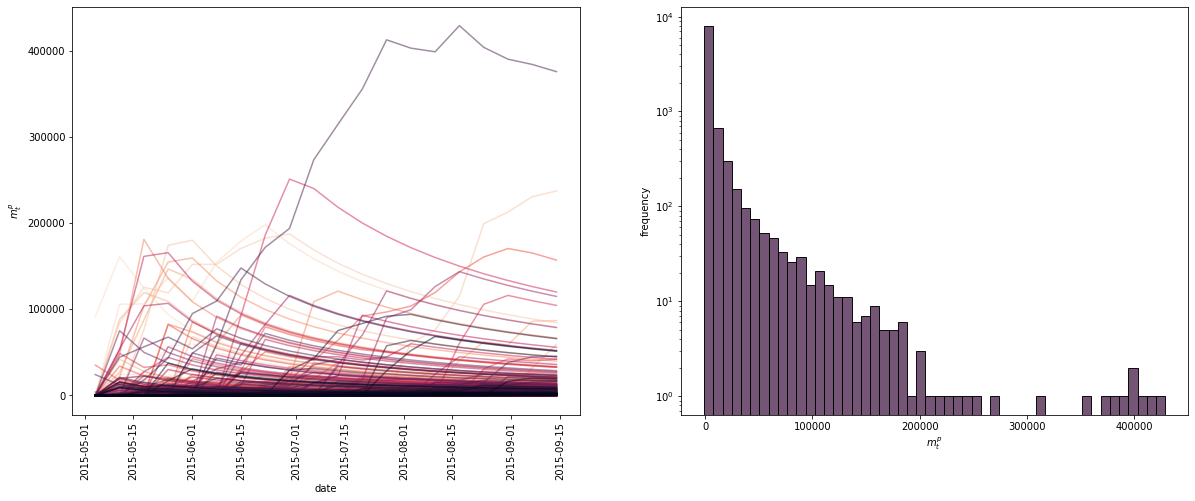

In [243]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,7.5))


# walk
sns.lineplot(data=user_wk,
    x="week_start", y="acp", hue="user_id",
    legend=False, palette=sns.color_palette("rocket_r", as_cmap=True),
    alpha=0.5, ci=False, ax=axs[0]);
#axs[0].set_yscale("log");
axs[0].tick_params(axis='x', rotation=90);
axs[0].set_ylabel("$m_{t}^{p}$");    
axs[0].set_xlabel("date");

# hist
sns.histplot(data=user_wk,
    x="acp", bins=50,
    color=sns.color_palette("rocket",10)[1],
    ax=axs[1]);
axs[1].set_yscale("log");    
axs[1].set_ylabel("frequency");
axs[1].set_xlabel("$m_{t}^{p}$");

In [ ]:
# fix retail rocket - missing category & price values - DONE

# download retail rocket for local dev - DONE
# plot ACP over time - DONE
# plot ACP distribution - DONE
# encapsulate

# sensitivity analysis - ACP vs mu0 & ACP vs sigma0




In [ ]:
# DEVELOP TOY EXAMPLE FOR THE PROFIT SIM